In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import ParameterGrid
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
df = pd.read_excel('GS4.xlsx')
df.sample(2)

,Year,Question
76,2019,What is meant by the term ‘constitutional mora...
175,2014,What does ‘accountability’ mean in the context...


In [2]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet,stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
import re
import string

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    
    question_words = {'explain', 'what', 'when', 'where', 'who', 'whom', 'which', 'why', 'how', 
                        'comment', 'discuss','following', 'example', 
                        'examine', 'state', 'critically','context', 'measures', 
                        'suggest', 'evaluate', 'describe', 'identify', 'illustrate','can','could','should',
                        'do','does','would','did','will','might'}
    stop_words.update(question_words)
    stop_words = list(stop_words)
    
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r' +', ' ', text)
    
    text = word_tokenize(text)
    filtered_sentence = [w for w in text if not w in stop_words]
    text = ' '.join(filtered_sentence)
    
    def lemmatize_sentence(sentence):
        nltk_tagged = pos_tag(nltk.word_tokenize(sentence))
        
        def nltk2wn_tag(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:          
                return None
    
        wordnet_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
        lemmatized_sentence = []
        for word, tag in wordnet_tagged:
            if tag is None:
                lemmatized_sentence.append(word)
            else:
                lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        return " ".join(lemmatized_sentence)
    return lemmatize_sentence(text)
    

In [5]:
text = df.Question[0]
print(text)
filtered_text = preprocess(text)
print(filtered_text)

What do you understand by ‘moral integrity’ and ‘professional efficiency in the context of corporate governance in India ? Illustrate with suitable examples.
understand moral integrity professional efficiency corporate governance india suitable example


In [6]:
def bert_model(df):
    questions = df['Question'].values.tolist()
    lemmatized_questions = [preprocess(question) for question in questions]
    
    param_grid = {
        'n_gram_range': [(1, 2), (1, 3),(1,4)],
        'questions': [lemmatized_questions, questions],
        'embedding_model': ['all-mpnet-base-v2', 'all-MiniLM-L6-v2'],
    }
    
    best_params = None
    best_outliers = float('inf')
    outliers_list = []
    
    representation = [PartOfSpeech("en_core_web_sm"),MaximalMarginalRelevance(diversity=0.2),KeyBERTInspired(top_n_words=30)]
    iteration = 0
    for params in ParameterGrid(param_grid):
        iteration+=1
        print(f"Iteration: {iteration}")
        # print(params)
        sentence_model = SentenceTransformer(params['embedding_model'])
        ctfidf_model = ClassTfidfTransformer(bm25_weighting=True,reduce_frequent_words=True)
        model = BERTopic(embedding_model=sentence_model,representation_model=representation,ctfidf_model=ctfidf_model,verbose=True,calculate_probabilities=True, nr_topics=8, n_gram_range=params['n_gram_range'], min_topic_size=3)
        topics, probs = model.fit_transform(params['questions'])
        
        unique_topics = len(set(topics)) - (1 if -1 in topics else 0)
        
        if unique_topics < 5 :
            continue
        
        outliers_count  = sum(1 for topic in topics if topic == -1)
        outliers_list.append(outliers_count)
        print(f"Outliers: {outliers_count}")
        
        if(outliers_count < best_outliers):
            best_outliers = outliers_count
            best_params = params
            print(f"Best Outliers: {best_outliers}")
            model.save('gs4_model')
            if(best_outliers < 20):
                break

In [7]:
bert_model(df)

Iteration: 1


2024-09-01 12:04:21,214 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 7/7 [00:34<00:00,  4.92s/it]
2024-09-01 12:04:55,702 - BERTopic - Embedding - Completed ✓
2024-09-01 12:04:55,712 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 12:05:16,114 - BERTopic - Dimensionality - Completed ✓
2024-09-01 12:05:16,117 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 12:05:16,170 - BERTopic - Cluster - Completed ✓
2024-09-01 12:05:16,173 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 12:05:56,892 - BERTopic - Representation - Completed ✓
2024-09-01 12:05:56,910 - BERTopic - Topic reduction - Reducing number of topics
2024-09-01 12:06:26,934 - BERTopic - Topic reduction - Reduced number of topics from 17 to 8
2024-09-01 12:06:26,997 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the envir

Outliers: 37
Best Outliers: 37
Iteration: 2


2024-09-01 12:06:33,340 - BERTopic - Embedding - Transforming documents to embeddings.
Batches:   0%|          | 0/7 [00:00<?, ?it/s]

: 

In [4]:
model = BERTopic.load('gs4_model')

In [5]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,37,-1_ethical competence_ethical conduct_ethical ...,"[ethical competence, ethical conduct, ethical ...",[recent time increase concern india develop ef...
1,0,92,0_management_job_situation_issue involve,"[management, job, situation, issue involve, ex...",[rajesh kumar senior public servant reputation...
2,1,29,1_nation ethic_ethic seek_law ethic_nation eth...,"[nation ethic, ethic seek, law ethic, nation e...",[believe adherence ethic human action ensure s...
3,2,20,2_three quotation_thinkersphilosophers quotati...,"[three quotation, thinkersphilosophers quotati...",[give three quotation great moral thinkersphil...
4,3,16,3_public service_public servant_civil service_...,"[public service, public servant, civil service...",[ten essential value need effective public ser...
5,4,5,4_emotional intelligence_emotional skill_learn...,"[emotional intelligence, emotional skill, lear...",[emotional intelligence develop people help in...
6,5,5,5_good governance_probity governance_governanc...,"[good governance, probity governance, governan...",[understand term governance good governance et...
7,6,4,6_crisis conscience_voice conscience_conscienc...,"[crisis conscience, voice conscience, conscien...",[meant crisis conscience manifest public domai...


In [6]:
questions = df['Question'].values.tolist()

In [7]:
model.visualize_documents(questions)

KeyboardInterrupt: 

In [ ]:
model.get_representative_docs()

{-1: ['Rehabilitation of human settlements is one of the important environmental impacts which always attracts controversy while planning major projects. Discuss the measures suggested for mitigation of this impact while proposing major developmental projects.',
  'Each year a large amount of plant material, cellulose, is deposited on the surface of Planet Earth. What are the natural processes this cellulose undergoes before yielding carbon dioxide, water and other end products ?',
  'There is a clear acknowledgement that Special Economic Zones (SEZs) are a tool of industrial development, manufacturing and exports. Recognising this potential, the whole instrumentality of SEZs require augmentation. Discuss the issue plaguing the success of SEZs with respect to taxation, governing laws and administration.'],
 0: ['Launched on 25th December, 2021, James Webb Space Telescope has been much in the news since then. What are its unique features which make it superior to its predecessor Space T

In [ ]:
num_words = 10
topics_ = []
for topic_num in range(len(model.get_topics())):
    # if topic_num != -1:   #-1 is the outlier class in BERTopic
    topic = model.get_topic(topic_num-1)
    if topic:  # Check if topic is not None
        top_words = [word for word, _ in topic[:num_words]]
        top_words = " ".join(top_words)
        topics_.append(f"Topic {topic_num}: {top_words}")

len(model.get_topics())

8

In [ ]:
topics_

['Topic 0: environmental impacts of environment dam failures environmental problems faced analyse the planning commission of industrial projects discuss the',
 'Topic 1: of agricultural agriculture food security of farmers land reforms agricultural farmers india what india india how',
 'Topic 2: cyber security security challenges terrorism internal security india of terrorism wing extremism security threat to extremism',
 'Topic 3: indian economy inclusive growth economic growth economy economic gdp growth in growth india industrial',
 'Topic 4: on climate climate change renewable energy india in climate india global warming predicted global conventional energy renewable',
 'Topic 5: disaster management urban floods floods india preparedness to disasters disasters national disaster intensity rainfall in disaster earthquakes',
 'Topic 6: indian patent patent law patents intellectual property novartis patent patenting patent patent application patenting by india protecting',
 'Topic 7: f

In [ ]:
topic_names = {0:'Outliers',1:'Agriculture',2:'Cyber Security and Terrorism',3:'Indian Economy and Growth',4:'Climate Change',5:'Disaster Management',6:'Indian Patent Law',7:'Foreign Direct Investment'}
num_words = 10
topics_ = {}
for topic_num in range(len(model.get_topics())):
    # if topic_num != -1:   #-1 is the outlier class in BERTopic
    topic = model.get_topic(topic_num-1)
    if topic:  # Check if topic is not None
        top_words = [word for word, _ in topic[:num_words]]
        topics_[topic_names[topic_num]] = top_words

In [ ]:
topics_

{'Outliers': ['environmental impacts',
  'of environment',
  'dam failures',
  'environmental',
  'problems faced',
  'analyse the',
  'planning commission',
  'of industrial',
  'projects',
  'discuss the'],
 'Agriculture': ['of agricultural',
  'agriculture',
  'food security',
  'of farmers',
  'land reforms',
  'agricultural',
  'farmers',
  'india what',
  'india',
  'india how'],
 'Cyber Security and Terrorism': ['cyber security',
  'security challenges',
  'terrorism',
  'internal security',
  'india',
  'of terrorism',
  'wing extremism',
  'security',
  'threat to',
  'extremism'],
 'Indian Economy and Growth': ['indian economy',
  'inclusive growth',
  'economic growth',
  'economy',
  'economic',
  'gdp',
  'growth in',
  'growth',
  'india',
  'industrial'],
 'Climate Change': ['on climate',
  'climate change',
  'renewable energy',
  'india in',
  'climate',
  'india',
  'global warming',
  'predicted global',
  'conventional energy',
  'renewable'],
 'Disaster Management'

In [ ]:
economics_list = topics_['Indian Economy and Growth']
economics_list.append('fdi')
economics_list.append('direct investment')
economics_list.append('commodity trade')
economics_list

['indian economy',
 'inclusive growth',
 'economic growth',
 'economy',
 'economic',
 'gdp',
 'growth in',
 'growth',
 'india',
 'industrial',
 ['fdi', 'direct investment'],
 'fdi',
 'direct investment',
 'commodity trade']

In [ ]:
topics_.pop('Foreign Direct Investment')

['fdi in',
 'investment fdi',
 'of fdi',
 'fdi',
 'the fdi',
 'fdi even',
 'direct investment',
 'for fdi',
 'india foreign',
 'commodity trade']

In [ ]:
topics_

{'Outliers': ['environmental impacts',
  'of environment',
  'dam failures',
  'environmental',
  'problems faced',
  'analyse the',
  'planning commission',
  'of industrial',
  'projects',
  'discuss the'],
 'Agriculture': ['of agricultural',
  'agriculture',
  'food security',
  'of farmers',
  'land reforms',
  'agricultural',
  'farmers',
  'india what',
  'india',
  'india how'],
 'Cyber Security and Terrorism': ['cyber security',
  'security challenges',
  'terrorism',
  'internal security',
  'india',
  'of terrorism',
  'wing extremism',
  'security',
  'threat to',
  'extremism'],
 'Indian Economy and Growth': ['indian economy',
  'inclusive growth',
  'economic growth',
  'economy',
  'economic',
  'gdp',
  'growth in',
  'growth',
  'india',
  'industrial',
  'fdi',
  'direct investment',
  'commodity trade'],
 'Climate Change': ['on climate',
  'climate change',
  'renewable energy',
  'india in',
  'climate',
  'india',
  'global warming',
  'predicted global',
  'convent

In [ ]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')
question_embeddings = sbert_model.encode(questions)

topic_embeddings = {}
for i in range(len(topics_.items())):
    topic_embeddings[topic_names[i]] = []
    for word in topics_[topic_names[i]]:
        topic_embeddings[topic_names[i]].append(sbert_model.encode(word))
        
topic_embeddings

{'Outliers': [array([-1.03203189e-02,  4.75112908e-02, -1.38941659e-02,  1.00450311e-02,
         -2.73714494e-02, -9.77245625e-03,  4.16924525e-03,  2.13734433e-02,
         -5.44716753e-02, -3.63669358e-02,  4.70849052e-02,  9.18591619e-02,
         -1.63273942e-02, -9.45141353e-03,  2.85834931e-02, -2.61249337e-02,
          2.97705308e-02, -2.92073097e-02, -1.15235768e-01,  1.20473066e-02,
         -3.28321196e-02, -1.26065491e-02,  5.23448363e-02,  1.80580257e-03,
         -2.33861487e-02,  1.42936977e-02, -1.43874353e-02,  4.19692136e-02,
          2.63777990e-02, -5.33266400e-04,  2.79834941e-02,  2.37154085e-02,
          1.58167183e-02, -5.93526475e-02,  1.68461099e-06,  6.63743122e-03,
         -2.37904787e-02, -1.45179341e-02,  6.05127483e-04,  6.25750422e-02,
          4.41095531e-02,  2.78381798e-02, -5.80034964e-03,  1.32801021e-02,
          5.20444177e-02, -4.04026844e-02,  9.83930379e-03, -8.21665898e-02,
         -3.05096600e-02, -4.31104749e-02, -9.12927091e-03,  1.2

In [ ]:
from sentence_transformers import CrossEncoder
crossencoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')


In [ ]:
question = questions[77]
topics_nearest = []
for i in range(len(topics_.items())):
    for word in topics_[topic_names[i]]:
        score = crossencoder.predict([(question,word)])
        topics_nearest.append({topic_names[i]: [score.tolist()[0],word]})

topics_nearest

[{'Outliers': [-8.878438949584961, 'environmental impacts']},
 {'Outliers': [-8.74455738067627, 'of environment']},
 {'Outliers': [-8.960944175720215, 'dam failures']},
 {'Outliers': [-8.204266548156738, 'environmental']},
 {'Outliers': [-8.041279792785645, 'problems faced']},
 {'Outliers': [-7.668860912322998, 'analyse the']},
 {'Outliers': [-8.922966003417969, 'planning commission']},
 {'Outliers': [-8.311570167541504, 'of industrial']},
 {'Outliers': [-8.767010688781738, 'projects']},
 {'Outliers': [-5.324734687805176, 'discuss the']},
 {'Agriculture': [-9.296239852905273, 'of agricultural']},
 {'Agriculture': [-8.776631355285645, 'agriculture']},
 {'Agriculture': [-8.962614059448242, 'food security']},
 {'Agriculture': [-8.941296577453613, 'of farmers']},
 {'Agriculture': [-8.86861801147461, 'land reforms']},
 {'Agriculture': [-9.109246253967285, 'agricultural']},
 {'Agriculture': [-8.966687202453613, 'farmers']},
 {'Agriculture': [-6.037407398223877, 'india what']},
 {'Agriculture

In [ ]:
topics_nearest.sort(key=lambda x: list(x.values())[0],reverse=True)
top_7_nearest = topics_nearest[:7]
top_7_nearest

[{'Disaster Management': [-3.406707763671875, 'disaster management']},
 {'Agriculture': [-4.593573093414307, 'india']},
 {'Cyber Security and Terrorism': [-4.593573093414307, 'india']},
 {'Indian Economy and Growth': [-4.593573093414307, 'india']},
 {'Climate Change': [-4.593573093414307, 'india']},
 {'Disaster Management': [-4.71356201171875, 'disasters']},
 {'Disaster Management': [-4.9261884689331055, 'in disaster']}]

In [ ]:
highest_scores = {}

for entry in topics_nearest:
    for topic, (score, word) in entry.items():
        if topic not in highest_scores or score > highest_scores[topic][0]:
            highest_scores[topic] = (score, word)

total = sum(score for score,word in highest_scores.values())



closest_topics = {topic:(score/total , word) for topic,(score,word) in highest_scores.items()}


closest_topics

{'Disaster Management': (0.10274600103108641, 'disaster management'),
 'Agriculture': (0.13854175307470729, 'india'),
 'Cyber Security and Terrorism': (0.13854175307470729, 'india'),
 'Indian Economy and Growth': (0.13854175307470729, 'india'),
 'Climate Change': (0.13854175307470729, 'india'),
 'Outliers': (0.16059352127516005, 'discuss the'),
 'Indian Patent Law': (0.1824934653949244, 'india protecting')}

In [ ]:
def score_generate(question):
    topics_nearest = []
    for i in range(len(topics_.items())):
        for word in topics_[topic_names[i]]:
            score = crossencoder.predict([(question,word)])
            topics_nearest.append({topic_names[i]: [score.tolist()[0],word]})
    
    highest_scores = {}
    for entry in topics_nearest:
        for topic, (score, word) in entry.items():
            if topic not in highest_scores or score > highest_scores[topic][0]:
                highest_scores[topic] = (score, word)

    total = sum(score for score,word in highest_scores.values())
    closest_topics = {topic:(score/total) for topic,(score,word) in highest_scores.items()}
    return closest_topics

In [ ]:
data = pd.DataFrame()

for i in range(len(questions)):
    data_ = pd.DataFrame(score_generate(questions[i]),index=[i])
    data_['Question'] = questions[i]
    
    data = pd.concat([data,data_],ignore_index=True)

In [ ]:
data.sample(5)


,Outliers,Agriculture,Cyber Security and Terrorism,Indian Economy and Growth,Climate Change,Disaster Management,Indian Patent Law,Question
169,0.122507,0.149143,0.149109,0.123760,0.148868,0.153088,0.153525,There is a clear acknowledgement that Special ...
63,0.138874,0.118461,0.139299,0.139299,0.139299,0.161586,0.163182,What are the challenges and opportunities of f...
197,0.197321,0.133669,0.133669,0.133669,0.133669,0.153651,0.114350,How does illegal trans-border migration pose a...
121,0.079156,0.155074,0.129807,0.123202,0.166155,0.161998,0.184607,Account for the failure of manufacturing secto...
139,0.151277,0.153760,0.087508,0.149462,0.150328,0.142829,0.164835,The scourge of terrorism is a grave challenge ...


In [ ]:
data['Topic'] = data.iloc[:,:-1].idxmin(axis=1)
data['Year'] = df['Year']
data.sample(5)

,Outliers,Agriculture,Cyber Security and Terrorism,Indian Economy and Growth,Climate Change,Disaster Management,Indian Patent Law,Question,Topic,Year
38,0.319027,0.096328,0.096328,0.096328,0.096328,0.144921,0.150739,What are the different elements of cyber secur...,Agriculture,2022
153,0.088174,0.145765,0.153391,0.152626,0.149634,0.149220,0.161191,Rehabilitation of human settlements is one of ...,Outliers,2016
26,0.101265,0.151591,0.149595,0.143526,0.151591,0.143320,0.159113,Discuss in detail the photochemical smog empha...,Outliers,2022
24,0.147207,0.140780,0.140780,0.124279,0.140780,0.153585,0.152587,The increase in life expectancy in the country...,Indian Economy and Growth,2022
51,0.173467,0.134630,0.134630,0.040782,0.134630,0.185218,0.196643,“Investment in infrastructure is essential for...,Indian Economy and Growth,2021


In [ ]:
data.to_excel('GS3_topics_v1.xlsx', index=False)

In [ ]:
data = pd.read_excel('GS3_topics_v1.xlsx')

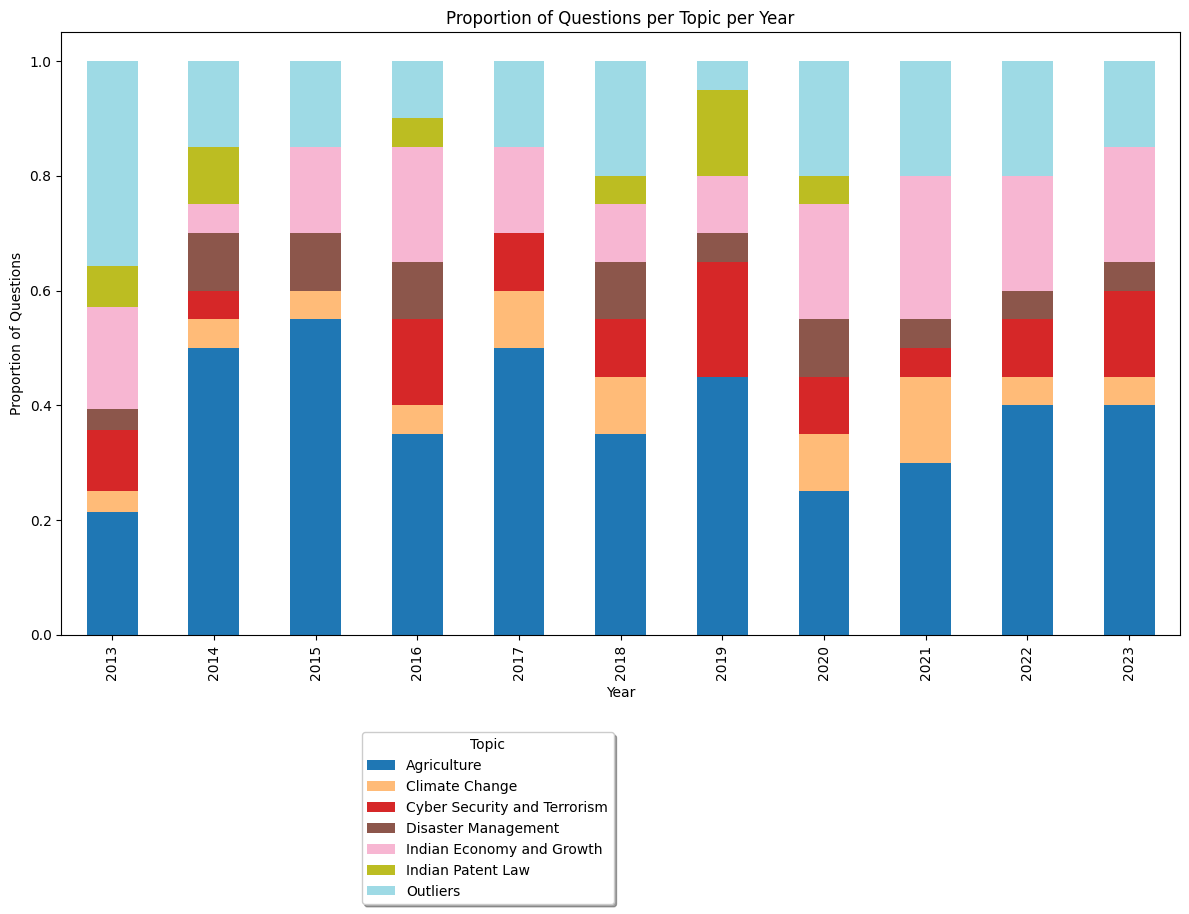

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Step 2: Count questions per topic per year
topic_year_counts = data.groupby(['Year', 'Topic']).size().reset_index(name='Count')

# Calculate the total number of questions per year
total_questions_per_year = topic_year_counts.groupby('Year')['Count'].transform('sum')

# Calculate the proportion of questions per topic per year
topic_year_counts['Proportion'] = topic_year_counts['Count'] / total_questions_per_year

# Step 3: Prepare data for plotting (normalized)
pivot_table = topic_year_counts.pivot(index='Year', columns='Topic', values='Proportion')

# Generate a list of colors from a colormap
num_topics = len(pivot_table.columns)
colors = plt.get_cmap('tab20', num_topics)

# Step 4: Plot the normalized data with different colors for each topic
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8), color=[colors(i) for i in range(num_topics)])

# Step 5: Customize the plot
plt.xlabel('Year')
plt.ylabel('Proportion of Questions')
plt.title('Proportion of Questions per Topic per Year')
plt.legend(title='Topic', loc='best', bbox_to_anchor=(0.5, -0.15), ncol=1, fancybox=True, shadow=True)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

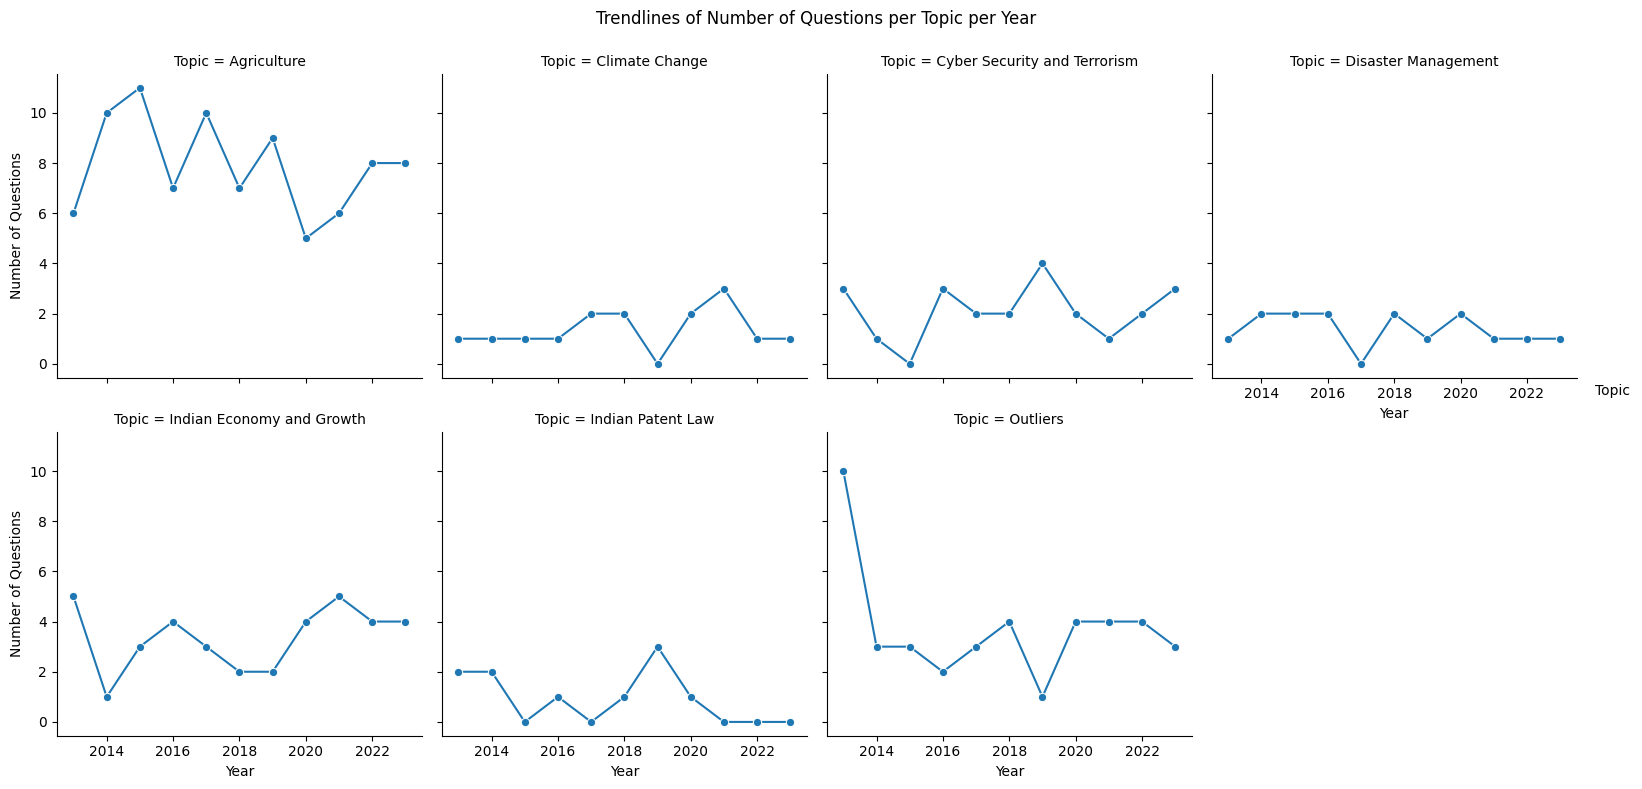

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

topic_year_counts = pd.crosstab(data['Year'], data['Topic'])

# Reset index to convert the pivot table to a DataFrame
topic_year_counts = topic_year_counts.reset_index()

# Melt the DataFrame to long format for Seaborn
melted_topic_year_counts = topic_year_counts.melt(id_vars='Year', var_name='Topic', value_name='Count')


g = sns.FacetGrid(melted_topic_year_counts, col='Topic', col_wrap=4, height=4, sharex=True, sharey=True)
g.map(sns.lineplot, 'Year', 'Count', marker='o')
g.set_axis_labels('Year', 'Number of Questions')
g.add_legend(title='Topic')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Trendlines of Number of Questions per Topic per Year')
plt.show()


<Axes: title={'center': 'Topic Frequency'}, xlabel='Topics', ylabel='Number Of Questions'>

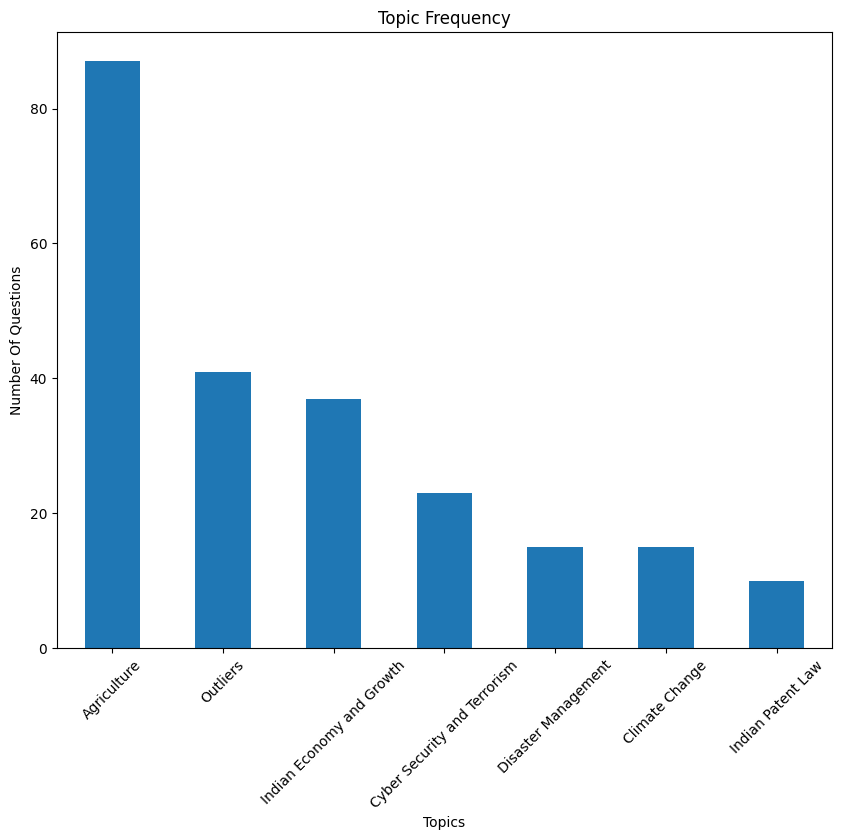

In [ ]:
data.Topic.value_counts().plot(kind='bar', figsize=(10, 8), title='Topic Frequency', xlabel='Topics', ylabel='Number Of Questions', rot=45)